# Testing Trading Strategies
The objective of this notebook is to provide a systematic approach to evaluating and comparing the performance of trading strategies using a range of metrics. We will explore key performance indicators that assess profitability, risk, consistency, and other important aspects of a strategy's performance. By examining multiple metrics, we can obtain a comprehensive understanding of a strategy's strengths, weaknesses, and overall performance characteristics.

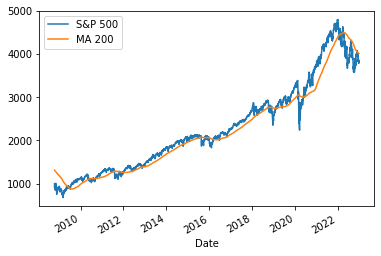

In [44]:
from datetime import datetime
import pandas as pd
import yfinance as yf

sp500 = yf.download('^GSPC','2008-01-01','2022-12-31', progress=False)['Close'].rename('S&P 500')
ma_200 = sp500.rolling(window=200).mean().rename('MA 200')
data = pd.concat([sp500, ma_200], axis=1).dropna()
data.plot();

In [45]:
def get_strategy_series(prices):
    prices = prices.rename('price')
    ma_200 = prices.rolling(window=200).mean().rename('MA 200')
    data = pd.concat([prices, ma_200], axis=1).dropna()
    data['long'] = data['MA 200'] < data['price']
    data['return'] = data['price'].pct_change()
    data.loc[~data['long'], 'return'] = 0
    data['return'] = data['return'] + 1
    return data['return'].cumprod().rename('strategy')

strategy = get_strategy_series(sp500)

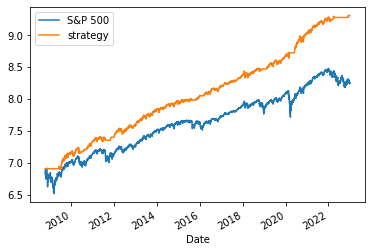

In [46]:
import numpy as np

comparison = pd.concat([sp500, strategy], axis=1).dropna()
comparison['strategy'] = comparison['strategy']*comparison['S&P 500'][0]
comparison.apply(lambda x: np.log(x)).plot();

## Evaluation metrics

In [49]:
def sharpe_measure(strategy, risk_free_rate):
    returns = strategy.pct_change().dropna()
    logret = returns.apply(lambda x: np.log(1+x))
    vol = np.std(logret)*np.sqrt(250)
    total_return = (returns + 1).cumprod()[-1]**(1/14) - 1
    return (total_return-risk_free_rate)/vol

sharpe_measure(strategy, 0.03) 

1.3750590394389912

In [68]:
sharpe_measure(sp500, 0.03)

0.196773437860486

In [53]:
def sortino_ratio(strategy, mar=0.08):
    returns = strategy.pct_change().dropna()
    returns_below = returns[returns < mar]
    msd = np.std(returns_below.apply(lambda x: np.log(1+x)))
    total_return = (returns + 1).cumprod()[-1]**(1/14) - 1
    return (total_return - mar)/(np.sqrt(msd))

sortino_ratio(strategy)

1.257030730350214

In [69]:
sortino_ratio(sp500)

-0.07889009610532928

In [55]:
def treynor_measure(strategy, risk_free_rate, market):
    returns = strategy.pct_change().dropna()
    vol = np.std(returns.apply(lambda x: np.log(1+x)))*np.sqrt(250)
    market_vol = np.std(market.apply(lambda x: np.log(1+x)))*np.sqrt(250)
    beta = strategy.corr(market) * (vol/market_vol)
    total_return = (returns + 1).cumprod()[-1]**(1/14) - 1
    return (total_return-risk_free_rate)/beta

treynor_measure(strategy, 0.03, sp500)

10.344064959349819

In [71]:
treynor_measure(sp500, 0.03, sp500)

1.4382046465301233

In [87]:
def jensen_measure(strategy, risk_free_rate, market):
    returns = strategy.pct_change().dropna()
    market_returns = market.pct_change().dropna()
    vol = np.std(returns.apply(lambda x: np.log(1+x)))*np.sqrt(250)
    market_vol = np.std(market_returns.apply(lambda x: np.log(1+x)))*np.sqrt(250)
    beta = returns.corr(market_returns) * (vol/market_vol)
    total_return = (returns + 1).cumprod()[-1]**(1/14) - 1
    market_return = (market_returns + 1).cumprod()[-1]**(1/14) - 1
    return total_return - (risk_free_rate + beta*(market_return - risk_free_rate))

jensen_measure(strategy, 0.03, sp500)

0.14393044205266808

In [88]:
jensen_measure(sp500, 0.03, sp500)

0.0

In [89]:
def modigliani(strategy, market):
    returns = strategy.pct_change().dropna()
    market_returns = market.pct_change().dropna()
    total_return = (returns + 1).cumprod()[-1]**(1/14) - 1
    market_return = (market_returns + 1).cumprod()[-1]**(1/14) - 1
    return total_return - market_return

modigliani(strategy, sp500)    

0.1156575721288573

In [90]:
modigliani(sp500, sp500)   

0.0

<AxesSubplot:xlabel='Date'>

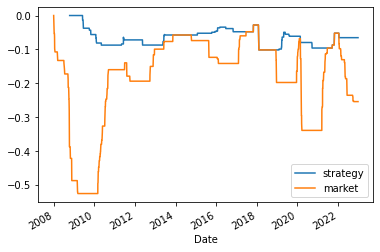

In [94]:
def maximum_drawdown_rolling(strategy):
    roll_max = strategy.rolling(250, min_periods=1).max()
    daily_drawdown = strategy/roll_max - 1.0
    max_daily_drawdown = daily_drawdown.rolling(250, min_periods=1).min()
    return max_daily_drawdown

md_strat = maximum_drawdown_rolling(strategy).rename('strategy')
md_market = maximum_drawdown_rolling(sp500).rename('market')
pd.concat([md_strat, md_market], axis=1).plot()

In [102]:
def tracking_error(strategy, benchmark):
    returns = strategy.pct_change().dropna().rename('strategy')
    benchmark = benchmark.pct_change().dropna().rename('benchmark')
    data = pd.concat([returns, benchmark], axis=1).dropna()
    data['difference'] = data['strategy'] - data['benchmark']
    return np.std(data['difference'])*100

tracking_error(strategy, sp500)

1.0406140790268807

In [103]:
tracking_error(sp500, sp500)

0.0

In [105]:
def information_ratio(strategy, benchmark):
    te = tracking_error(strategy, benchmark)
    returns = strategy.pct_change().dropna()
    benchmark_returns = benchmark.pct_change().dropna()
    total_return = (returns + 1).cumprod()[-1]**(1/14) - 1
    benchmark_return = (benchmark_returns + 1).cumprod()[-1]**(1/14) - 1
    return (total_return - benchmark_return)/te

information_ratio(strategy, sp500)

0.11114357806595626